# DDoS Attacks Detection and Characterization


Import pyton libraries

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime 

In [2]:
df = pd.read_csv('ddos_dataset.csv')

df_copy = df.copy()

/tmp/ipykernel_6536/3984028547.py:1: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('ddos_dataset.csv')


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64239 entries, 0 to 64238
Data columns (total 88 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    64239 non-null  int64  
 1   Flow ID                       64239 non-null  object 
 2    Source IP                    64239 non-null  object 
 3    Source Port                  64239 non-null  int64  
 4    Destination IP               64239 non-null  object 
 5    Destination Port             64239 non-null  int64  
 6    Protocol                     64239 non-null  int64  
 7    Timestamp                    64239 non-null  object 
 8    Flow Duration                64239 non-null  int64  
 9    Total Fwd Packets            64239 non-null  int64  
 10   Total Backward Packets       64239 non-null  int64  
 11  Total Length of Fwd Packets   64239 non-null  float64
 12   Total Length of Bwd Packets  64239 non-null  float64
 13   

# Section 1 – Data exploration and pre-processing

## 1. Investigate the provided DDoS attack dataset

I dati sono stati raccolti il giorno 1 dicembre 2018 dalle 09:17:11 alle 13:34:27.

In [4]:
#Fix column names
df.columns = [col.strip().replace(" ", "") for col in df.columns] 

#Drop unnecessary column
df.drop(columns=['Unnamed:0'],inplace=True)

#Fix similarHTTP column values
df['SimillarHTTP'] = df['SimillarHTTP'].apply(lambda x : 1 if x != 0 else 0)
print(df['SimillarHTTP'].value_counts())

SimillarHTTP
1    40960
0    23279
Name: count, dtype: int64


In [5]:
#In this section we remove columns that have the same value in every row (no variability), since they are meanningless for the analysis or modeling
#We can notice that 12 columns have just one unique value, so we went from 88 columns to 76 columns 

#unique values per column
uniqueVpc = df.apply(lambda col: col.unique())

#Columns with just one unique value
cwov = uniqueVpc[uniqueVpc.apply(len) == 1].index

print("Columns meaningless beacuse they have the same value on all rows:")
print(cwov)

df = df.drop(columns=cwov)

Columns meaningless beacuse they have the same value on all rows:
Index(['BwdPSHFlags', 'FwdURGFlags', 'BwdURGFlags', 'FINFlagCount',
       'PSHFlagCount', 'ECEFlagCount', 'FwdAvgBytes/Bulk',
       'FwdAvgPackets/Bulk', 'FwdAvgBulkRate', 'BwdAvgBytes/Bulk',
       'BwdAvgPackets/Bulk', 'BwdAvgBulkRate'],
      dtype='object')


In [6]:
df.describe()

,SourcePort,DestinationPort,Protocol,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,...,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,SimillarHTTP,Inbound
count,64239.000000,64239.000000,64239.000000,6.423900e+04,64239.000000,64239.000000,64239.000000,6.423900e+04,64239.000000,64239.000000,...,6.423900e+04,6.423900e+04,6.423900e+04,6.423900e+04,6.423900e+04,6.423900e+04,6.423900e+04,6.423900e+04,64239.000000,64239.000000
mean,25267.368608,30715.252884,14.362864,5.150614e+06,18.814848,1.304036,6699.521630,2.153348e+03,613.992948,588.863043,...,9.026629e+03,4.878774e+03,1.687791e+04,6.204895e+03,1.155553e+06,2.613584e+05,1.555321e+06,8.908522e+05,0.637619,0.919566
std,24710.413442,20347.990914,4.706001,2.249713e+07,462.305336,25.199720,20510.320389,9.087201e+04,585.691655,584.276284,...,2.045563e+05,1.424082e+05,3.828583e+05,1.667756e+05,5.341380e+06,1.574889e+06,6.993415e+06,4.571276e+06,0.480692,0.271966
min,0.000000,0.000000,0.000000,1.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,779.000000,12435.500000,17.000000,1.000000e+00,2.000000,0.000000,123.000000,0.000000e+00,53.000000,36.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000
50%,29661.000000,30797.000000,17.000000,2.000000e+00,2.000000,0.000000,1050.000000,0.000000e+00,393.000000,375.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,1.000000
75%,48510.500000,49041.500000,17.000000,2.087700e+04,2.000000,0.000000,2944.000000,0.000000e+00,1464.000000,1464.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000,1.000000
max,65518.000000,65535.000000,17.000000,1.200000e+08,85894.000000,1862.000000,176000.000000,8.829488e+06,3564.000000,2020.000000,...,1.678654e+07,2.853681e+07,6.783473e+07,8.349846e+06,1.147455e+08,5.275036e+07,1.147455e+08,1.147455e+08,1.000000,1.000000


### BASIC TRAFFIC STATISTICS

In [7]:
n_flow=df['FlowID'].nunique() # 64239
n_src_ip = df["SourceIP"].nunique()
n_dst_ip = df["DestinationIP"].nunique()

print(f"Number of unique source IPs: {n_src_ip}")
print(f"Number of unique destination IPs: {n_dst_ip}")

Number of unique source IPs: 216
Number of unique destination IPs: 245


### CLASS DISTRIBUTION

In [8]:
df_masked=df[df['label']=='benign']
num_benign=df_masked['label'].count() # 5658

num_attack=len(df)-num_benign # 58581
num_attackpertype=df[df['label']!='benign'].groupby(["label"]).size()   # int(num_attacktype[i])
num_attackpertype

label
ddos_dns        5369
ddos_ldap       5928
ddos_mssql      5911
ddos_netbios    5830
ddos_ntp         986
ddos_snmp       5984
ddos_ssdp       5970
ddos_syn        5480
ddos_tftp       5261
ddos_udp        5876
ddos_udp_lag    5986
dtype: int64

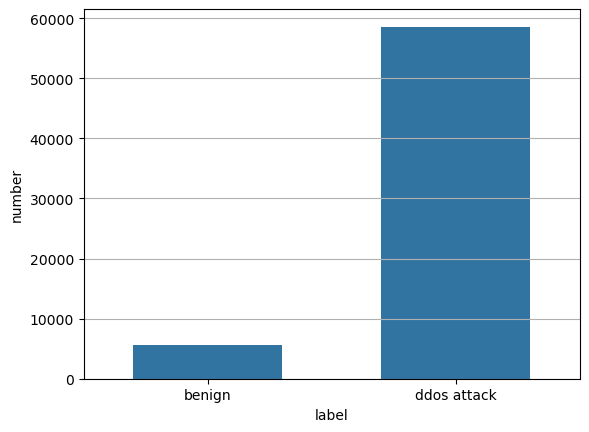

In [9]:
df_benign= pd.DataFrame({
    'label' : ['benign','ddos attack'], 
    'number' : [num_benign, num_attack]
})

sns.barplot(
    data = df_benign, # which dataframe you want to use as the source data
    x = 'label', # which column to use for x-axis
    y = 'number', # which column to use for y-axis
    width=0.6
)
plt.grid(True)             
plt.grid(axis='x')
plt.show()

/tmp/ipykernel_6536/3302619406.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'number of attacks' : [int(num_attackpertype[i])   for i in range(0,len(num_attackpertype))]


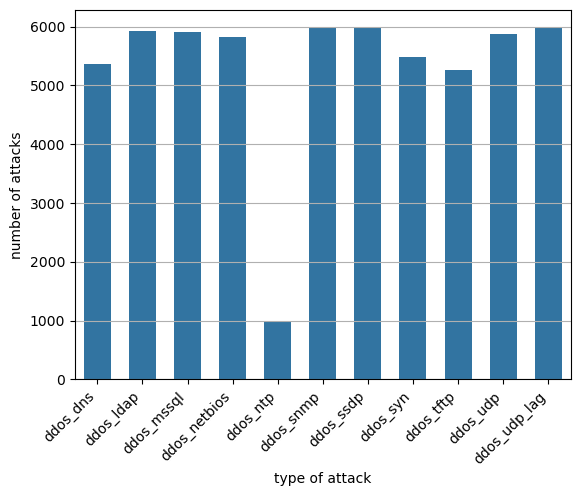

In [10]:
attack_type=['ddos_dns', 'ddos_ldap', 'ddos_mssql','ddos_netbios','ddos_ntp','ddos_snmp','ddos_ssdp','ddos_syn','ddos_tftp','ddos_udp','ddos_udp_lag']
df_attack = pd.DataFrame({
    'type of attack' : attack_type, 
    'number of attacks' : [int(num_attackpertype[i])   for i in range(0,len(num_attackpertype))]
})

sns.barplot(
    data = df_attack, # which dataframe you want to use as the source data
    x = 'type of attack', # which column to use for x-axis
    y = 'number of attacks', # which column to use for y-axis
    width=0.6
)
plt.grid(True)             
plt.grid(axis='x') 
plt.xticks(rotation=45, ha='right')
plt.show()

In [11]:
df['label_simplified']= df['label'].apply(lambda x: "benign" if x=='benign' else "attack")

<Axes: xlabel='DestinationPort', ylabel='Proportion'>

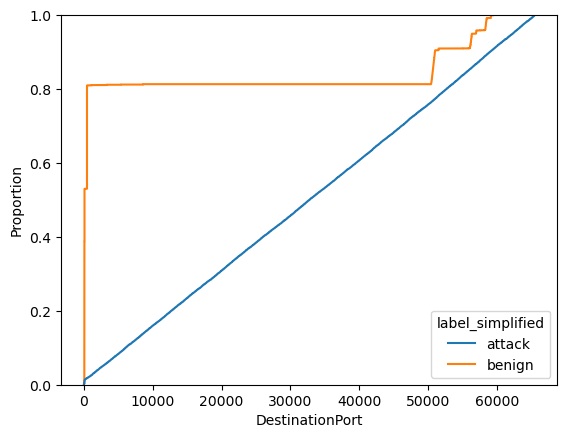

In [12]:
sns.ecdfplot(
    data = df,
    x = 'DestinationPort', # the column that you want to compute ecdf, they will be in the order from short to long length (numerical order)
    hue = 'label_simplified')

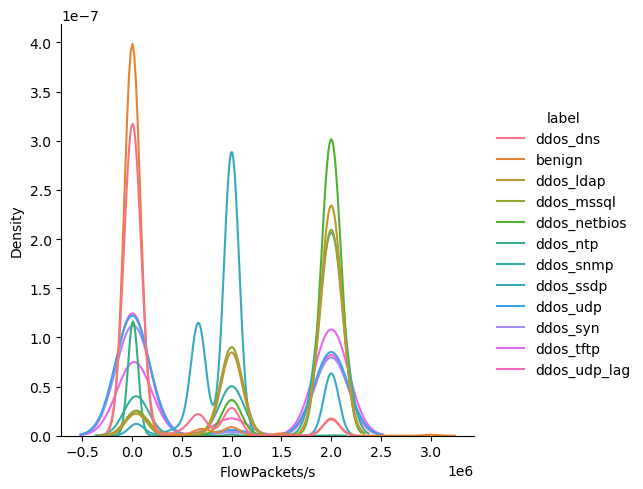

In [13]:
sns.displot(
    data = df, 
    x = "FlowPackets/s", # the column you want to check
    hue = "label", # check the distribution of different flower types
    kind = "kde" # a kernel density estimate (KDE) of the distribution, you can remove this to see the change
)

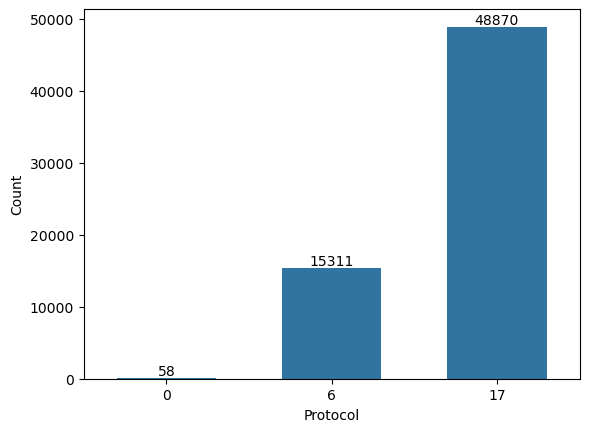

In [14]:
df_prot=df.groupby('Protocol')['Protocol'].count()
df_prot=pd.DataFrame(df_prot)
df_prot.columns=['Count']

ax = sns.barplot(data = df_prot, x = df_prot.index, y = 'Count', width=0.6)

# Aggiungere i valori sopra le barre
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height), ha='center', va='bottom')
plt.show()

/tmp/ipykernel_6536/1905931592.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_masked['Timestamp'] = pd.to_datetime(df_masked['Timestamp'])


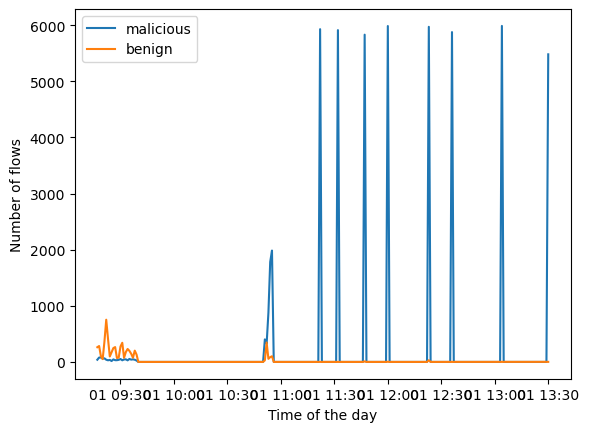

In [15]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df_masked['Timestamp'] = pd.to_datetime(df_masked['Timestamp'])

df_time_b=df_masked.set_index('Timestamp')
df_time_b=df_time_b.resample('1min').size()

df_time=df.set_index('Timestamp')
df_time=df_time.resample('1min').size()
df_time_m=df_time-df_time_b

plt.figure()
sns.lineplot(data = df_time_m, label='malicious')
sns.lineplot(data = df_time_b,label='benign')
plt.xlabel("Time of the day")
plt.ylabel("Number of flows")
plt.show()

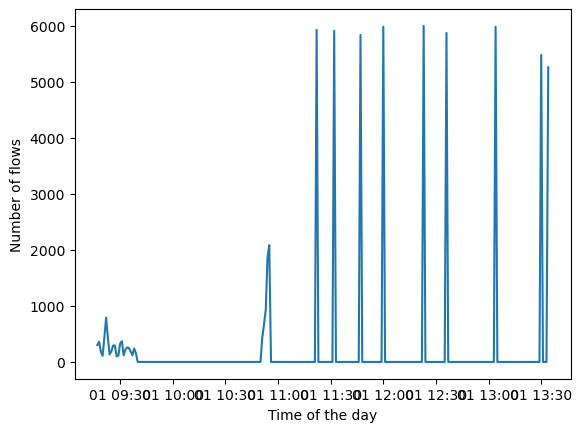

In [16]:
plt.figure()
sns.lineplot(data = df_time)
plt.xlabel("Time of the day")
plt.ylabel("Number of flows")
plt.show()

## 2. Generate additional features

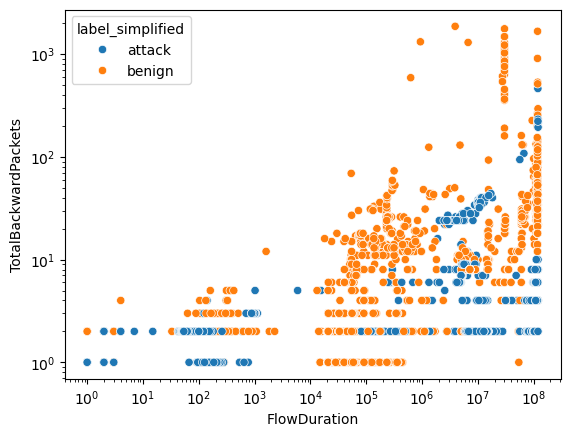

In [17]:
df['TotalBytes'] = df['TotalLengthofFwdPackets'] + df['TotalLengthofBwdPackets']
df['TotalPackets'] = df['TotalFwdPackets'] + df['TotalBackwardPackets']
df['AveragePacketLength'] = df['TotalBytes'] / df['TotalPackets']

df['Fwd/BwdPacketRatio'] = df['TotalFwdPackets'] / (df['TotalBackwardPackets'] + 1)

df['TrafficScore'] = df['TotalBytes'] * df['FlowPackets/s']

sns.scatterplot(
    data=df,
    x='FlowDuration',
    y='TotalBackwardPackets', # ????????
    hue='label_simplified') 
plt.xscale('log')
plt.yscale('log')
plt.show()

### Time

In [18]:
reference_date = min(df['Timestamp'])
df['Timestamp'] = (df['Timestamp'] - reference_date).dt.total_seconds()

## Categorial features encoding

In [19]:
#Funzione per convertire IP in intero, qui convertiamo i source ip
def ip_to_int(ip):
    try:
        # Funziona sia per IPv4 che per IPv6
        return int(ipaddress.ip_address(ip))
    except:
        # Se c'è un errore (es. valore nullo o stringa errata), ritorna None o -1
        return None

#Applicare la funzione alla colonna 'Src IP'
df['SourceIpInt'] = df['SourceIP'].apply(ip_to_int)
df['DestinationIPInt'] = df['DestinationIP'].apply(ip_to_int)

print(df[['SourceIP', 'SourceIpInt']].head())
print(df[['DestinationIP', 'DestinationIPInt']].head())

df.info()
#si creeranno due colonne nuove con gli IP convertiti in interi

#Convert 'Timestamp' to seconds since the first timestamp
reference_date = min(df['Timestamp'])
df['Timestamp'] = (df['Timestamp']-reference_date).dt.total_seconds()

       SourceIP SourceIpInt
0    172.16.0.5        None
1  192.168.50.1        None
2    172.16.0.5        None
3    172.16.0.5        None
4    172.16.0.5        None
  DestinationIP DestinationIPInt
0  192.168.50.1             None
1    172.16.0.5             None
2  192.168.50.1             None
3  192.168.50.1             None
4  192.168.50.1             None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64239 entries, 0 to 64238
Data columns (total 83 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   FlowID                   64239 non-null  object 
 1   SourceIP                 64239 non-null  object 
 2   SourcePort               64239 non-null  int64  
 3   DestinationIP            64239 non-null  object 
 4   DestinationPort          64239 non-null  int64  
 5   Protocol                 64239 non-null  int64  
 6   Timestamp                64239 non-null  float64
 7   FlowDuration             64239 non

AttributeError: Can only use .dt accessor with datetimelike values

## 3. Data Pre-processing

### Correlation matrix

In [ ]:
from sklearn.decomposition import PCA

# Compute the correlation matrix
correlation_matrix = df.drop(columns=['label','label_simplified']).corr().abs()

# Compute the heatmap
plt.figure(figsize=(5,4))
sns.heatmap(correlation_matrix, cmap='Blues', annot=True, vmin=.0, vmax=1, cbar_kws={'label':'Correlation'})
plt.xlabel('Feature')
plt.ylabel('Feature')
plt.title('Correlation matrix')
plt.show()

### PCA

In [ ]:
pca = PCA(random_state=42)
pca.fit(df)

# cella sotto ancora da modificare ....

In [ ]:
# describe how much of the dataset variability is indicated by a given amount of features
explained_variance = pca.explained_variance_ratio_

# evaluate the total dataset variability while increasing the variables
cumul_exp_var = np.cumsum(explained_variance)

# percentage value to better understand the best number of components
perc_cumul_exp_var = cumul_exp_var * 100

# make the plot of cumulative explained variance wrt number of components
plt.figure(figsize=(5, 3.5))
plt.plot(perc_cumul_exp_var, marker='o')
plt.xlabel('# Principal Components (PCs)')
plt.ylabel('Cumulative explained variance [%]')
plt.xticks([i for i in range(4)], [i for i in range(1,5)])
plt.grid()
plt.title(f'3 PCs explain {round(perc_cumul_exp_var[2], 2)}% of $\sigma^2$')
plt.tight_layout()
plt.show()